In [1]:
!pip -q install torch scikit-learn matplotlib numpy pandas tqdm


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [6]:
from google.colab import files
files.upload()

Saving labels.csv to labels (1).csv


{'labels (1).csv': b'label\nbusiness\nbusiness\nsport\nbusiness\npolitics\nsport\nsport\npolitics\nentertainment\npolitics\nbusiness\nentertainment\nsport\nbusiness\nentertainment\nbusiness\ntech\nentertainment\nbusiness\nentertainment\nbusiness\nsport\nbusiness\nentertainment\nbusiness\nsport\nentertainment\nsport\npolitics\nsport\nsport\npolitics\ntech\nentertainment\nbusiness\nbusiness\nbusiness\nsport\ntech\nsport\ntech\npolitics\nbusiness\nsport\ntech\ntech\ntech\nbusiness\nbusiness\ntech\nentertainment\nbusiness\npolitics\nbusiness\nentertainment\npolitics\npolitics\npolitics\nbusiness\nbusiness\nbusiness\nentertainment\nentertainment\nbusiness\nsport\nentertainment\nbusiness\nbusiness\npolitics\nsport\npolitics\npolitics\ntech\nsport\nbusiness\nsport\nsport\nentertainment\nbusiness\nbusiness\nsport\nsport\nbusiness\nentertainment\nentertainment\nsport\nsport\nsport\nentertainment\nsport\nsport\nbusiness\npolitics\nbusiness\nsport\nbusiness\nentertainment\nentertainment\nbusiness

In [9]:
#Charger les embeddings & labels
X_w2v = np.load("X_w2v.npy")
X_glove = np.load("X_glove.npy")
labels_df = pd.read_csv("labels.csv")

labels = labels_df["label"].values
label_names = sorted(np.unique(labels))
label_to_id = {l:i for i,l in enumerate(label_names)}
y = np.array([label_to_id[l] for l in labels])

print(X_w2v.shape, X_glove.shape, y.shape)
print(label_names)


(2225, 200) (2225, 100) (2225,)
['business', 'entertainment', 'politics', 'sport', 'tech']


In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_val.shape)


(1780, 200) (445, 200)


In [11]:
#Dataset & DataLoader
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EmbeddingDataset(X_train, y_train)
val_ds   = EmbeddingDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)


In [12]:
#Modèle BiLSTM

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        # x: [B, D] → [B, 1, D]
        x = x.unsqueeze(1)
        _, (h_n, _) = self.lstm(x)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        h = self.dropout(h)
        return self.fc(h)


In [13]:
#Entraînement

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTMClassifier(
    input_dim=X_train.shape[1],
    hidden_dim=128,
    num_classes=len(label_names)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10


In [14]:
for epoch in range(EPOCHS):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS} | loss={np.mean(train_losses):.4f}")


Epoch 1/10 | loss=1.4754
Epoch 2/10 | loss=0.9171
Epoch 3/10 | loss=0.3820
Epoch 4/10 | loss=0.2421
Epoch 5/10 | loss=0.2012
Epoch 6/10 | loss=0.1817
Epoch 7/10 | loss=0.1793
Epoch 8/10 | loss=0.1702
Epoch 9/10 | loss=0.1543
Epoch 10/10 | loss=0.1500


In [15]:
#Évaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(yb.numpy())

acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")

print("Accuracy:", acc)
print("F1-score:", f1)


Accuracy: 0.946067415730337
F1-score: 0.943616869268195


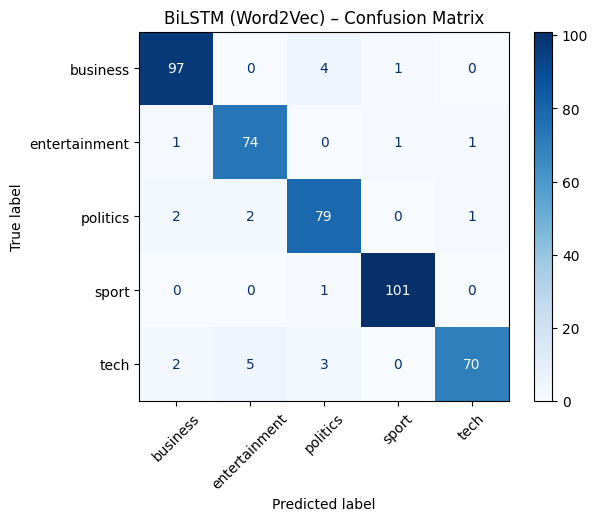

In [16]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("BiLSTM (Word2Vec) – Confusion Matrix")
plt.show()


In [19]:
torch.save(model.state_dict(), "bilstm_w2v.pt")

results = {
    "model": "BiLSTM_Word2Vec",
    "accuracy": acc,
    "f1_macro": f1
}
pd.DataFrame([results]).to_csv("results_bilstm_w2v.csv", index=False)

print("Saved model & results")


Saved model & results
